#**DCGAN**

 * The Deep Convolutional GAN is created here and the performance of the same is monitored.

* Data Set used is MNIST Fashion DataSet, having total 70000 images, in greay scale in size 28X28.



In [27]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Conv2D,Flatten, Dropout,MaxPooling2D, Activation,BatchNormalization,LeakyReLU,Conv2DTranspose,Reshape
import tensorflow as tf
from IPython import display
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import time
from tqdm import tqdm
import matplotlib.image as mpimg
import glob
import imageio
import PIL

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load and Preprocess the dataset for the model

(train_images,train_labels),(_,_)=tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
# Verification of the image dimensions
train_images.shape

(60000, 28, 28)

In [4]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
#Normalizing the images between (-1,1)
train_images = (train_images-127.5)/127.5

In [5]:
buffer_size = 60000
batch_size = 300

In [6]:
# Creating tensorflow dataset generator object
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [7]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## **Defining Generator Model**

In [9]:
def generator_model():
  model = Sequential(name="Generator")
  model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model
  
generator = generator_model()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        51

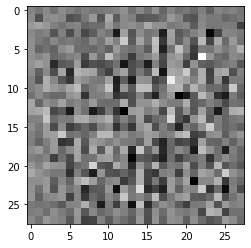

In [12]:
# Testing the generator model 
generator = generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training = False)

plt.imshow(generated_image[0,:,:,0],cmap="gray")

##**Defining Discriminator Model**

In [13]:
def discriminator_model():
    model = Sequential(name="Discriminator")
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

discriminator = discriminator_model()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

In [14]:
# Testing Discrimininator Model
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00240251]], shape=(1, 1), dtype=float32)


## **Defining Loss Function**

In [16]:
cross_entropy = BinaryCrossentropy(from_logits=True)

In [17]:
# Discriminator Loss Function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## **Defining Optimizers**

In [20]:
#Generator Optimizer
generator_optimizer = Adam(1e-4)
# Diszcriminator Optimizers
discriminator_optimizer = Adam(1e-4)

## **Training Modules**

In [37]:
@tf.function
def train_step(images,batch_size,noise_dim):
    noise = tf.random.normal([batch_size, noise_dim])

    # tf.GradientTape() -- Record operations
    # inputs is being "watched". Trainable variables are automatically watched.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [40]:
def train(dataset, epochs,batch_size,noise_dim, path=''):
  for epoch in range(1, epochs+1):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch,batch_size,noise_dim)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    if epoch == 1 or epoch%10==0:
      generate_and_save_images(generator, epoch, seed, path=path)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed, path=path)

 

In [33]:
def generate_and_save_images(model, epoch, test_input, path=''):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
  
  if (epoch % 10) == 0:
      filename = path + 'DCGAN_at_epoch_{:04d}.png'.format(epoch)
      plt.savefig(filename)
      filename = path + 'DCGAN_generator_model_%03d.h5' % (epoch)
      model.save(filename)
  plt.show()

## **Defining Parameters**

In [35]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
buffer_size = 60000
batch_size = 300

In [36]:
# Defining the Noise Seed
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

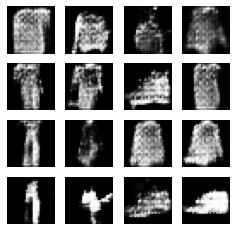

In [41]:
mypath = r"/content/drive/MyDrive/Colab Notebooks/GAN/Assignment_3_DL_Edureka"
train(train_dataset, 50,batch_size,noise_dim, mypath)